# Blob Analysis

The past two activities taught you how to segment a region of interest according to grayscale or 
color, and how to clean up a thresholded image using morphological operations. Let us assume you 
have succeeded in getting a clean segmented binary image, where white blobs of connected pixels 
are the regions of interest and black pixels are the background. In this activity, we learn how to 
**extract features** from these blobs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from matplotlib.patches import Rectangle
from skimage import measure, morphology
from scipy.stats import norm, gaussian_kde
from scipy.ndimage import binary_dilation, binary_erosion, binary_closing, binary_opening

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
# plt.rcParams["text.usetex"] = True

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Image segmentation

In [2]:
def NCC(img):
    img = img/255
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    I = R + G + B
    I[I == 0] = 100000
    r, g = R/I, G/I
    b = 1 - r - g
    return r, g, b

In [3]:
def gaussian_PDF(orig_img, roi_img):
    mu = np.mean(roi_img)
    sigma = np.std(roi_img)
    gaussian = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(orig_img - mu)**2/(2*sigma**2))
    return gaussian

In [4]:
def parametric_segmentation(orig_img, roi_img):
    orig_img_red = gaussian_PDF(NCC(orig_img)[0], NCC(roi_img)[0])
    orig_img_green = gaussian_PDF(NCC(orig_img)[1], NCC(roi_img)[1])
    segmented_img = orig_img_red * orig_img_green
    return segmented_img

In [5]:
def nonparametric_segmentation(orig_img, roi_img, bins):
    r_orig = (NCC(orig_img)[0]*(bins-1)).astype(int)
    g_orig = (NCC(orig_img)[1]*(bins-1)).astype(int)
    r_roi = (NCC(roi_img)[0]*(bins-1)).astype(int)
    g_roi = (NCC(roi_img)[1]*(bins-1)).astype(int)
    
    img_matrix, xbins, ybins = np.histogram2d(g_roi.flatten(), r_roi.flatten(), 
                                                    bins = bins, range = [[0, bins], [0, bins]])
    
    # iterate all rows and columns of segmented_img
    # array of zeros with same shape as roi_img - basis image!
    segmented_img = np.zeros(NCC(orig_img)[0].shape)
    for i in range(NCC(orig_img)[0].shape[0]): 
        for j in range(NCC(orig_img)[0].shape[1]):
            segmented_img[i,j] = img_matrix[g_orig[i,j], r_orig[i,j]]
            
    return segmented_img

In [6]:
def image_segment(orig_img, roi_img, bins):
    fig, ax = plt.subplots(1, 3, figsize = (12, 4), constrained_layout = True)
    
    ax[0].imshow(orig_img)
    ax[0].set_title("Original image")
    ax[1].imshow(parametric_segmentation(orig_img, roi_img), cmap = "gray")
    ax[1].set_title("Parametric")
    ax[2].imshow(nonparametric_segmentation(orig_img, roi_img, bins), cmap = "gray")
    ax[2].set_title("Nonparametric (bins = {})".format(bins))
    
    for a in ax:
        a.axis("off")

## Structuring elements

In [7]:
# Structuring elements
square_5 = np.zeros((11, 11))
square_5[3:8, 3:8] = 1

square_5s = np.zeros((11, 11))
square_5s[3:8, 3:8] = 1

***
## Malaria cells

We have done feature extraction using ImageJ. Now we will use MATLAB or python functions to integrate the feature extraction in our program. We may want to do this if we need to do experiments repeatedly.


In [8]:
def rgb2gray(filename):
    rgbimg = Image.open(filename + ".png")
    grayimg = np.array(rgbimg.convert("L"))
    return grayimg

In [9]:
def rgb_img(filename):
    orig_img = Image.open(filename + ".png")
    rgb_img = np.array(orig_img.convert("RGB"))
    return rgb_img

In [10]:
malaria = rgb2gray("malaria")
malaria_RGB = rgb_img("malaria")
malaria_ROI = rgb_img("malaria ROI")
malaria_threshold = (malaria > 100) & (malaria < 160)

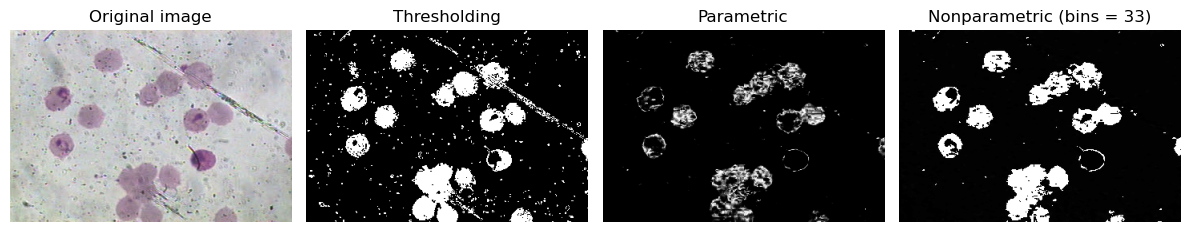

In [11]:
fig, ax = plt.subplots(1, 4, figsize = (12, 4), tight_layout = True)

ax[0].imshow(malaria_RGB)
ax[0].set_title("Original image")
ax[1].imshow(malaria_threshold, cmap = "gray")
ax[1].set_title("Thresholding")
ax[2].imshow(parametric_segmentation(malaria_RGB, malaria_ROI), cmap = "gray")
ax[2].set_title("Parametric")
ax[3].imshow(nonparametric_segmentation(malaria_RGB, malaria_ROI, 33), cmap = "gray")
ax[3].set_title("Nonparametric (bins = 33)")

for a in ax:
    a.axis("off")
    
fig.savefig("malaria segmentation.png")

Performing morphological cleaning on the thresholded image as it retained most of the shape of the cell,

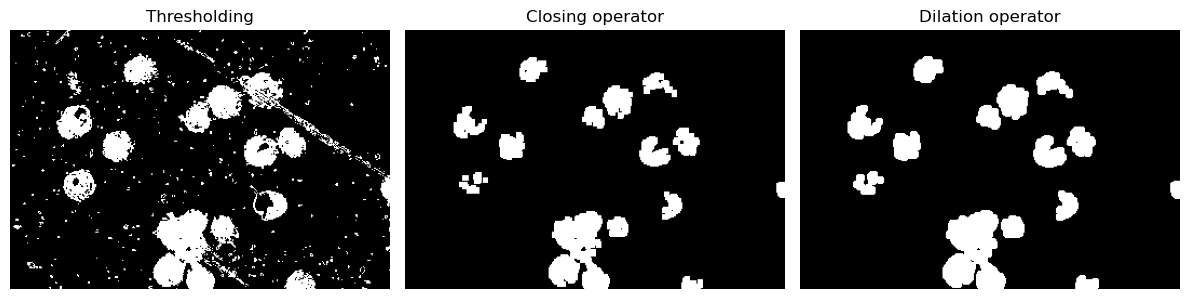

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), tight_layout = True)

ax[0].imshow(malaria_threshold, cmap = "gray")
ax[0].set_title("Thresholding")
ax[1].imshow(binary_opening(malaria_threshold, square_5), cmap = "gray")
ax[1].set_title("Closing operator")
ax[2].imshow(binary_dilation(binary_opening(malaria_threshold, square_5)), cmap = "gray")
ax[2].set_title("Dilation operator")

for a in ax:
    a.axis("off")
    
fig.savefig("malaria morph operations.png")

In [13]:
malaria_cleaned = binary_dilation(binary_opening(malaria_threshold, square_5))
malaria_labels = measure.label(malaria_cleaned)
malaria_props = measure.regionprops(malaria_labels)

In [14]:
# Dataframe results for reference
malaria_results = measure.regionprops_table(malaria_labels, properties = ("area", "centroid"))
malaria_df = pd.DataFrame(malaria_results)

malaria_centx = malaria_df["centroid-1"].to_numpy()
malaria_centy = malaria_df["centroid-0"].to_numpy()
malaria_area = malaria_df["area"].to_numpy()

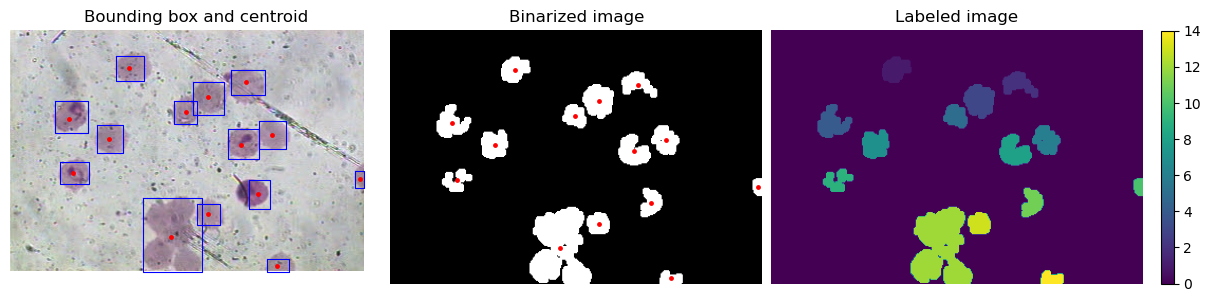

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), constrained_layout = True)

ax[0].imshow(malaria_RGB)
ax[0].scatter(malaria_centx, malaria_centy, s = 6, color = "red")
ax[0].set_title("Bounding box and centroid")
ax[1].imshow(malaria_cleaned, cmap = "gray")
ax[1].scatter(malaria_centx, malaria_centy, s = 6, color = "red")
ax[1].set_title("Binarized image")
ax[2].set_title("Labeled image")
malaria_watershed = ax[2].imshow(malaria_labels)
plt.colorbar(malaria_watershed, ax = ax[2], fraction = 0.034)

for prop in malaria_props:
    minr, minc, maxr, maxc = prop.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax[0].plot(bx, by, color = "blue", linewidth = 0.8)

for a in ax:
    a.axis("off")
    
fig.savefig("malaria regionprops.png")

***
## [Red blood cells](https://media.istockphoto.com/id/1335904460/photo/target-cells-with-abnormal-red-blood-cells-in-blood-smear.jpg?s=612x612&w=0&k=20&c=nde1u65jE04JdFPSJpckDfsqoWRnQ4PDkXkLFEZ_vIw=)

In [16]:
rbc = rgb_img("blood cells")
rbc_ROI = rgb_img("blood cells ROI")

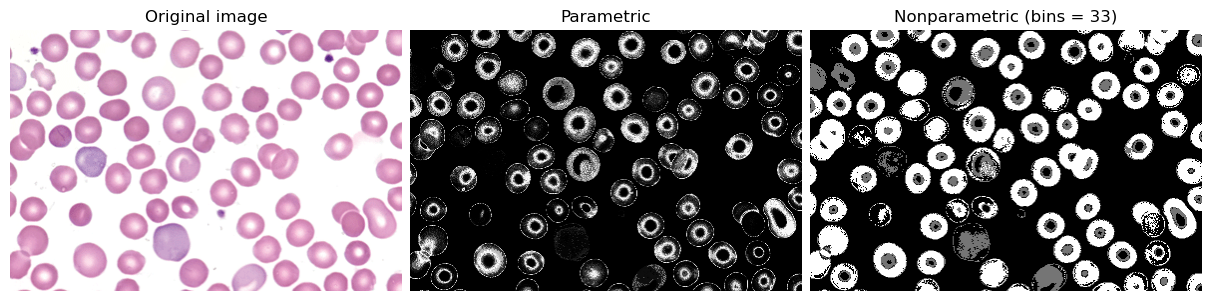

In [17]:
image_segment(rbc, rbc_ROI, 33)
plt.savefig("rbc segmentation.png")

In [18]:
rbc_nonpara = nonparametric_segmentation(rbc, rbc_ROI, 33)
rbc_cleaned = morphology.remove_small_holes(binary_opening(binary_closing(rbc_nonpara)))
rbc_cleaned = morphology.remove_small_objects(rbc_cleaned)

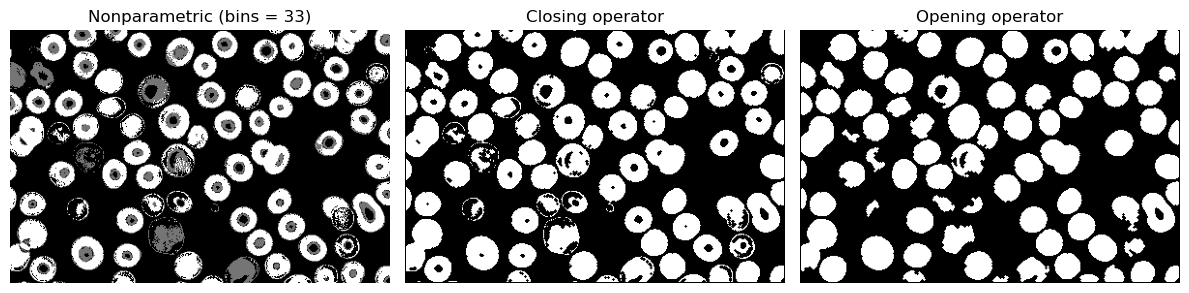

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), tight_layout = True)

ax[0].imshow(rbc_nonpara, cmap = "gray")
ax[0].set_title("Nonparametric (bins = 33)")
ax[1].imshow(binary_closing(rbc_nonpara), cmap = "gray")
ax[1].set_title("Closing operator")
ax[2].imshow(rbc_cleaned, cmap = "gray")
ax[2].set_title("Opening operator")

for a in ax:
    a.axis("off")
    
fig.savefig("rbc morph operations.png")

In [20]:
rbc_labels = measure.label(rbc_cleaned)
rbc_props = measure.regionprops(rbc_labels)

In [21]:
rbc_results = measure.regionprops_table(rbc_labels, properties = ("area", "centroid", "eccentricity", "perimeter"))
rbc_df = pd.DataFrame(rbc_results)

rbc_centx = rbc_df["centroid-1"].to_numpy()
rbc_centy = rbc_df["centroid-0"].to_numpy()
rbc_area = rbc_df["area"].to_numpy()
rbc_ecct = rbc_df["eccentricity"].to_numpy()
rbc_perimeter = rbc_df["perimeter"].to_numpy()

# trial to limit the blob detection - similar to remove_small_objs
rbc_area_filt = np.where(rbc_area > 50)
rbc_centx_filt = rbc_centx[rbc_area_filt]
rbc_centy_filt = rbc_centy[rbc_area_filt]

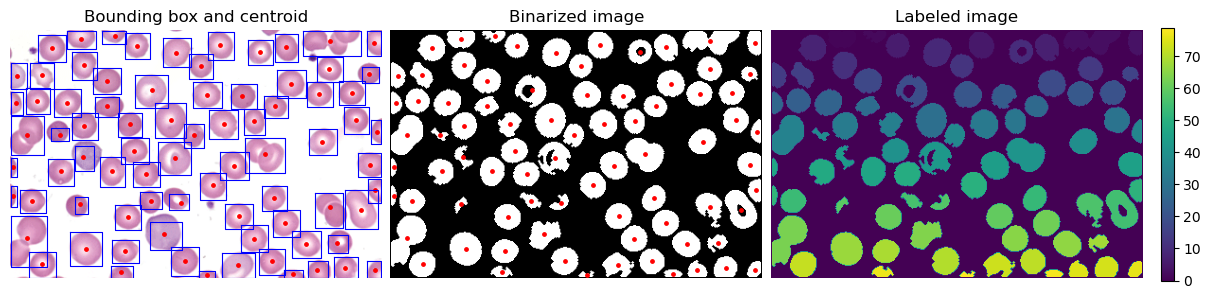

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), constrained_layout = True)

ax[0].imshow(rbc)
ax[0].scatter(rbc_centx, rbc_centy, s = 6, color = "red")
ax[0].set_title("Bounding box and centroid")
ax[1].imshow(rbc_cleaned, cmap = "gray")
ax[1].scatter(rbc_centx, rbc_centy, s = 6, color = "red")
ax[1].set_title("Binarized image")
ax[2].set_title("Labeled image")
rbc_watershed = ax[2].imshow(rbc_labels)
plt.colorbar(rbc_watershed, ax = ax[2], fraction = 0.034)

for prop in rbc_props:
    minr, minc, maxr, maxc = prop.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax[0].plot(bx, by, color = "blue", linewidth = 0.8)

for a in ax:
    a.axis("off")
    
fig.savefig("rbc regionprops.png")

### Statistical analysis

Adapted from discussions on normal distribution and Gaussian KDE from Physics 191.

In [23]:
def normal_dist_fit(data_array):
    domain = np.linspace(data_array.min(), data_array.max(), 1000)
    mu, sigma = norm.fit(data_array)
    return domain, norm.pdf(domain, mu, sigma)

In [24]:
def kde_dist_fit(data_array):
    domain = np.linspace(data_array.min(), data_array.max(), len(data_array))
    kernel = gaussian_kde(data_array)
    kernel_pdf = kernel(domain)
    return domain, kernel_pdf

In [25]:
area_data = rbc_area[rbc_area_filt]
ecct_data = rbc_ecct[rbc_area_filt]
perim_data = rbc_perimeter[rbc_area_filt]

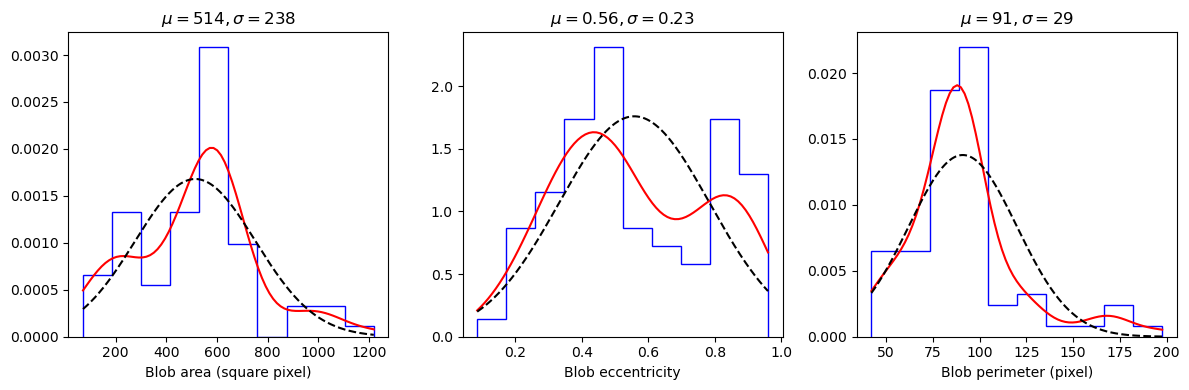

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), tight_layout = True)

ax[0].hist(area_data, color = "blue", histtype = "step", density = True)
ax[0].plot(kde_dist_fit(area_data)[0], kde_dist_fit(area_data)[1], color = "red")
ax[0].plot(normal_dist_fit(area_data)[0], normal_dist_fit(area_data)[1], color = "black", linestyle = "--")
ax[0].set_title(r"$\mu = {:.0f}, \sigma = {:.0f}$".format(np.mean(area_data), np.std(area_data)))
ax[0].set_xlabel("Blob area (square pixel)")

ax[1].hist(ecct_data, color = "blue", histtype = "step", density = True)
ax[1].plot(kde_dist_fit(ecct_data)[0], kde_dist_fit(ecct_data)[1], color = "red")
ax[1].plot(normal_dist_fit(ecct_data)[0], normal_dist_fit(ecct_data)[1], color = "black", linestyle = "--")
ax[1].set_title(r"$\mu = {:.2f}, \sigma = {:.2f}$".format(np.mean(ecct_data), np.std(ecct_data)))
ax[1].set_xlabel("Blob eccentricity")

ax[2].hist(perim_data, color = "blue", histtype = "step", density = True)
ax[2].plot(kde_dist_fit(perim_data)[0], kde_dist_fit(perim_data)[1], color = "red")
ax[2].plot(normal_dist_fit(perim_data)[0], normal_dist_fit(perim_data)[1], color = "black", linestyle = "--")
ax[2].set_title(r"$\mu = {:.0f}, \sigma = {:.0f}$".format(np.mean(perim_data), np.std(perim_data)))
ax[2].set_xlabel("Blob perimeter (pixel)")

fig.savefig("rbc stats.png")

***
## [Diatoms and desmids](https://www.micromagus.net/microscopes/pondlife_plants01.html)

In [27]:
diatoms = rgb_img("diatoms")
diatoms_ROI = rgb_img("diatoms ROI")

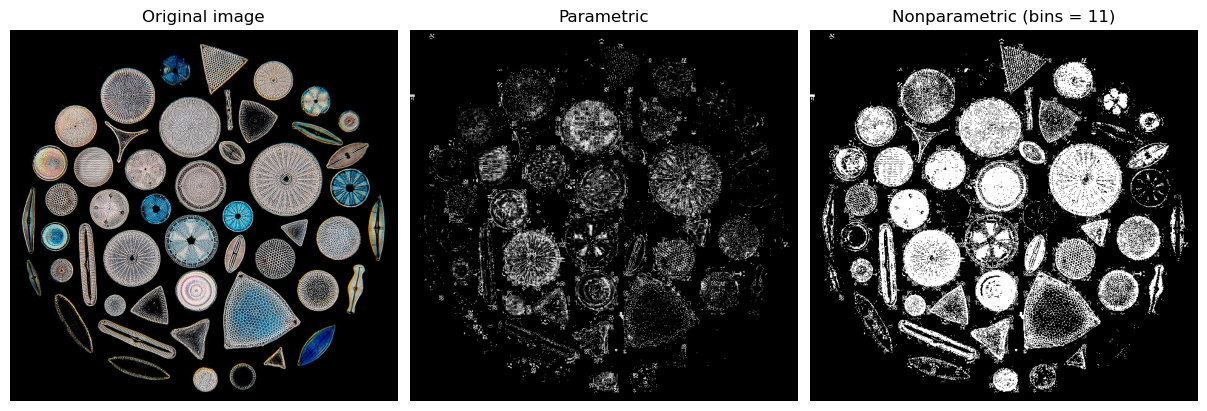

In [28]:
image_segment(diatoms, diatoms_ROI, 11)
plt.savefig("diatoms segmentation.png")

In [29]:
algae_nonpara = nonparametric_segmentation(diatoms, diatoms_ROI, 11)
algae_cleaned = morphology.remove_small_holes(binary_opening(algae_nonpara), area_threshold = 2048)
algae_cleaned = morphology.remove_small_objects(algae_cleaned, min_size = 500)

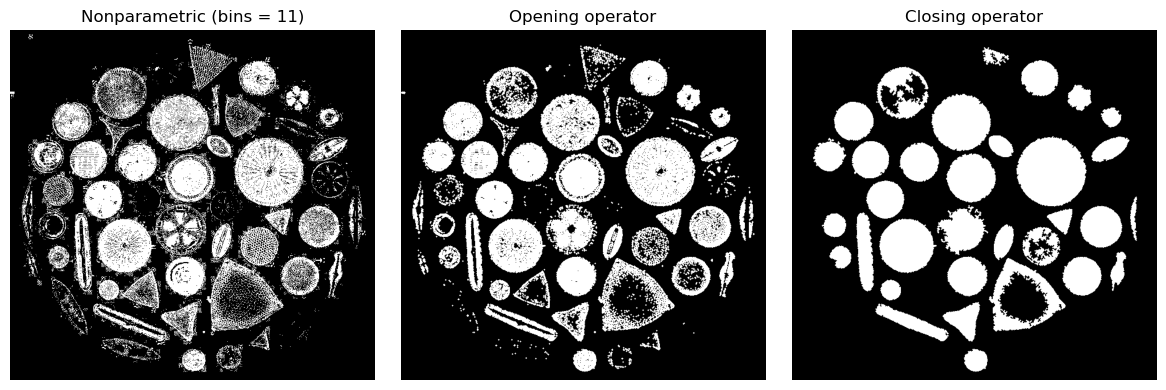

In [30]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), tight_layout = True)

ax[0].imshow(algae_nonpara, cmap = "gray")
ax[0].set_title("Nonparametric (bins = 11)")
ax[1].imshow(binary_opening(algae_nonpara), cmap = "gray")
ax[1].set_title("Opening operator")
ax[2].imshow(algae_cleaned, cmap = "gray")
ax[2].set_title("Closing operator")

for a in ax:
    a.axis("off")
    
fig.savefig("diatoms morph operations.png")

In [31]:
algae_labels = measure.label(algae_cleaned)
algae_props = measure.regionprops(algae_labels)

In [32]:
algae_results = measure.regionprops_table(algae_labels, 
                                          properties = ("area", "centroid", "eccentricity", "perimeter"))
algae_df = pd.DataFrame(algae_results)

algae_centx = algae_df["centroid-1"].to_numpy()
algae_centy = algae_df["centroid-0"].to_numpy()
algae_area = algae_df["area"].to_numpy()
algae_ecct = algae_df["eccentricity"].to_numpy()
algae_perimeter = algae_df["perimeter"].to_numpy()

# trial to limit the blob detection - similar to remove_small_objs
algae_area_filt = np.where(algae_area > 250)
algae_centx_filt = algae_centx[algae_area_filt]
algae_centy_filt = algae_centy[algae_area_filt]

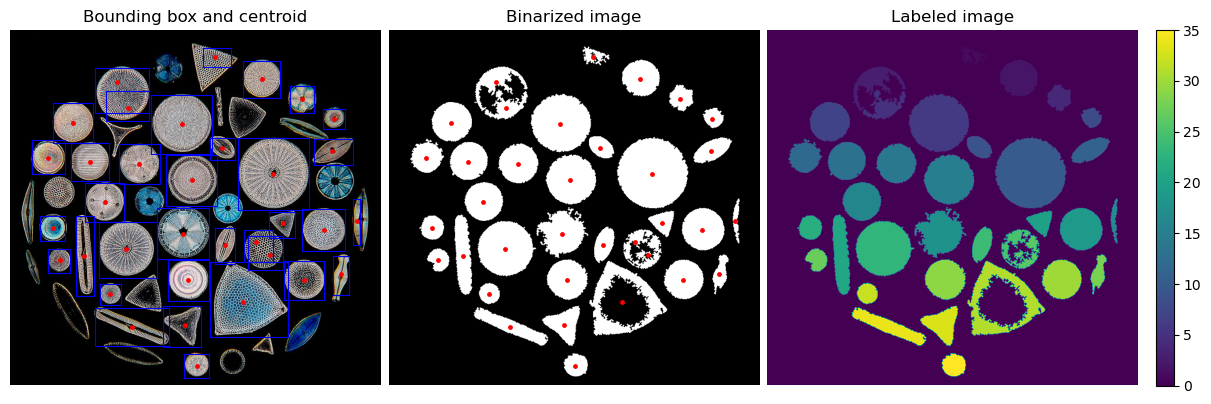

In [33]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), constrained_layout = True)

ax[0].imshow(diatoms)
ax[0].scatter(algae_centx_filt, algae_centy_filt, s = 6, color = "red")
ax[0].set_title("Bounding box and centroid")
ax[1].imshow(algae_cleaned, cmap = "gray")
ax[1].scatter(algae_centx_filt, algae_centy_filt, s = 6, color = "red")
ax[1].set_title("Binarized image")
ax[2].set_title("Labeled image")
algae_watershed = ax[2].imshow(algae_labels)
plt.colorbar(algae_watershed, ax = ax[2], fraction = 0.048)

for prop in algae_props:
    if prop.area > 250:
        minr, minc, maxr, maxc = prop.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax[0].plot(bx, by, color = "blue", linewidth = 0.8)

for a in ax:
    a.axis("off")
    
fig.savefig("diatoms regionprops.png")

### Statistical analysis

In [34]:
area_data = algae_area[algae_area_filt]
ecct_data = algae_ecct[algae_area_filt]
perim_data = algae_perimeter[algae_area_filt]

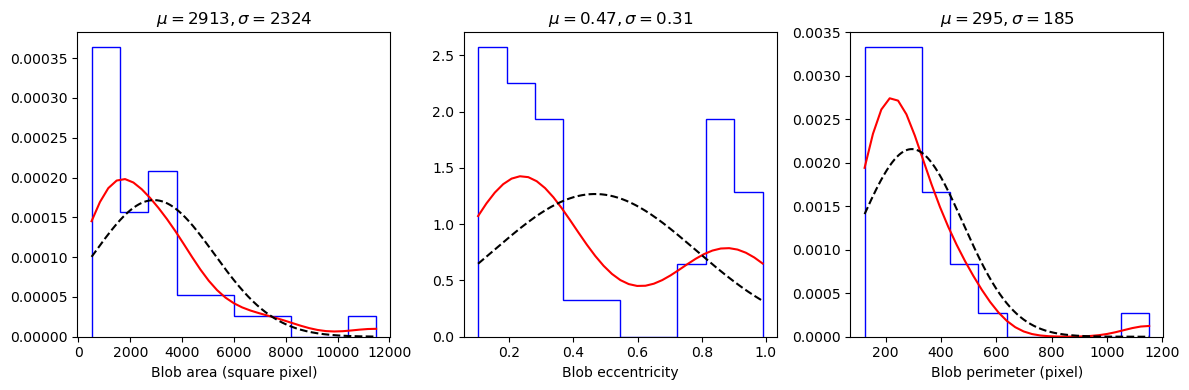

In [35]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4), tight_layout = True)

ax[0].hist(area_data, color = "blue", histtype = "step", density = True)
ax[0].plot(kde_dist_fit(area_data)[0], kde_dist_fit(area_data)[1], color = "red")
ax[0].plot(normal_dist_fit(area_data)[0], normal_dist_fit(area_data)[1], color = "black", linestyle = "--")
ax[0].set_title(r"$\mu = {:.0f}, \sigma = {:.0f}$".format(np.mean(area_data), np.std(area_data)))
ax[0].set_xlabel("Blob area (square pixel)")

ax[1].hist(ecct_data, color = "blue", histtype = "step", density = True)
ax[1].plot(kde_dist_fit(ecct_data)[0], kde_dist_fit(ecct_data)[1], color = "red")
ax[1].plot(normal_dist_fit(ecct_data)[0], normal_dist_fit(ecct_data)[1], color = "black", linestyle = "--")
ax[1].set_title(r"$\mu = {:.2f}, \sigma = {:.2f}$".format(np.mean(ecct_data), np.std(ecct_data)))
ax[1].set_xlabel("Blob eccentricity")

ax[2].hist(perim_data, color = "blue", histtype = "step", density = True)
ax[2].plot(kde_dist_fit(perim_data)[0], kde_dist_fit(perim_data)[1], color = "red")
ax[2].plot(normal_dist_fit(perim_data)[0], normal_dist_fit(perim_data)[1], color = "black", linestyle = "--")
ax[2].set_title(r"$\mu = {:.0f}, \sigma = {:.0f}$".format(np.mean(perim_data), np.std(perim_data)))
ax[2].set_xlabel("Blob perimeter (pixel)")

fig.savefig("diatoms stats.png")